In [1]:
# --- my modules
from sample_selection import sample_selection
from proposed_algorithm import domain_invariant_unsupervised_sample_selection as diuss 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mtply
import pandas as pd
import scipy as sp
import scipy.io as sp_io
from scipy.spatial.distance import cdist

from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

## Corn Cargill

In [3]:
# data stored at "https://github.com/caseykneale/ChemometricsData.jl/tree/master/data/Cargill_Corn"
datafolder_url = "https://raw.githubusercontent.com/caseykneale/ChemometricsData.jl/master/data/Cargill_Corn/"
reference_values_df = pd.read_csv(datafolder_url + "property_values.csv",sep = ",", decimal = ".")
print(reference_values_df.columns,reference_values_df.shape)

Index(['Moisture', 'Oil', 'Protein', 'Starch'], dtype='object') (80, 4)


In [4]:
n_cal = 56
primary_name = "mp5"
x_primary_all_df = pd.read_csv(datafolder_url + primary_name +"_spectra.csv",sep = ",", decimal = ".")

rng = np.random.RandomState(7620987)
cal_samples = rng.choice(x_primary_all_df.shape[0], n_cal, replace = False)
nocal_samples = np.asarray([ii for ii in range(x_primary_all_df.shape[0]) if ii not in cal_samples])

x_all = np.array(x_primary_all_df)[cal_samples,0:]
x_test = np.array(x_primary_all_df)[nocal_samples,0:]
print(x_all.shape, x_test.shape)

(56, 700) (24, 700)


### <span style="color:#00BDFF">Setting the response variable (Y)</span>

In [5]:
Moisture_all = np.array(reference_values_df.loc[:,'Moisture'])[cal_samples]
Oil_all = np.array(reference_values_df.loc[:,'Oil'])[cal_samples]
Protein_all = np.array(reference_values_df.loc[:,"Protein"])[cal_samples]
Starch_all = np.array(reference_values_df.loc[:,"Starch"])[cal_samples]

Moisture_test = np.array(reference_values_df.loc[:,'Moisture'])[nocal_samples]
Oil_test = np.array(reference_values_df.loc[:,'Oil'])[nocal_samples]
Protein_test = np.array(reference_values_df.loc[:,'Protein'])[nocal_samples]
Starch_test = np.array(reference_values_df.loc[:,'Starch'])[nocal_samples]

Moisture_all.shape = (Moisture_all.shape[0],1)
Oil_all.shape = (Oil_all.shape[0],1)
Protein_all.shape = (Protein_all.shape[0],1)
Starch_all.shape = (Starch_all.shape[0],1)

Moisture_test.shape = (Moisture_test.shape[0],1)
Oil_test.shape = (Oil_test.shape[0],1)
Protein_test.shape = (Protein_test.shape[0],1)
Starch_test.shape = (Starch_test.shape[0],1)

print(Moisture_all.shape, Oil_all.shape,Protein_all.shape, Starch_all.shape)
print(Moisture_test.shape, Oil_test.shape, Protein_test.shape, Starch_test.shape)

(56, 1) (56, 1) (56, 1) (56, 1)
(24, 1) (24, 1) (24, 1) (24, 1)


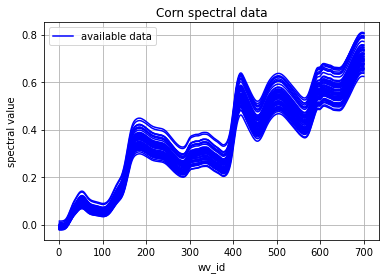

In [6]:
# visualize data
wv_range = np.arange(1,x_all.shape[1]+1) 
plt.plot(wv_range,x_all[0], c = "blue", label = "available data") #(Row 1)
plt.plot(wv_range,x_all.T, c = "blue") #.T is the transpose matrix (Column 1)
plt.xlabel("wv_id")
plt.ylabel("spectral value")
plt.title("Corn spectral data")
plt.legend()
plt.grid()
plt.show()

proportion of variance first pc's:  [9.91236e-01 7.42400e-03 5.50000e-04 3.40000e-04 2.14000e-04 1.21000e-04
 4.70000e-05 2.50000e-05 1.60000e-05 9.00000e-06 6.00000e-06 4.00000e-06
 3.00000e-06 2.00000e-06 1.00000e-06 1.00000e-06 1.00000e-06 0.00000e+00
 0.00000e+00 0.00000e+00]


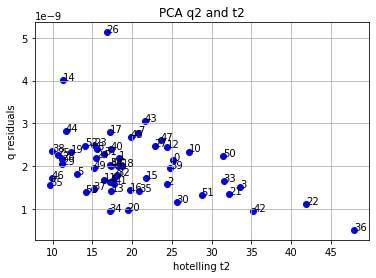

In [7]:
# initial pca for exploratory analysis
pca_mu = x_all.mean(axis=0)  # mean(axis=0) is an array with the mean per column

X_c = x_all - pca_mu #Mean centering X_initial
X_c_t = np.ascontiguousarray(X_c.transpose()) 
cov_X = X_c_t.dot(X_c)/X_c.shape[0] # ([X_c^T]*[[X_c]) / n ; 
svd_cov_X = np.linalg.svd(cov_X) # Singular Value Decomposition

chosen_pc = 20 #sugested number 

pc_loadings = svd_cov_X[0][:,0:chosen_pc] # first 25 coulums from left eigenvectors U
tscores = (x_all - pca_mu).dot(pc_loadings) #X centered * Loadings
x_all_predicted = tscores.dot(pc_loadings.T) + pca_mu

q_residuals = np.mean(np.power(x_all - x_all_predicted,2),axis=1) # Mean per row of (Xi -Xp)^2
hotelling_t2 = np.diag(tscores.dot(np.diag(1/svd_cov_X[1][0:chosen_pc])).dot(tscores.T)) 
#Dig( tscores(155,10)* Dia(1/SVD_Cov_X(650,1))*tscores^T)

print("proportion of variance first pc's: ",np.round(svd_cov_X[1]/np.sum(svd_cov_X[1]),6)[0:chosen_pc])
# Eigenvalue(i)/Sum(Eigenvalues)
# Eigenvalues = expalined variance

plt.scatter(hotelling_t2,q_residuals,c="blue")
for ii in range(hotelling_t2.shape[0]):
    plt.text(hotelling_t2[ii],q_residuals[ii], str(ii))
plt.grid()
plt.xlabel("hotelling t2")
plt.ylabel("q residuals")
plt.title("PCA q2 and t2")
plt.show()


In [ ]:
tscores

In [ ]:
# --- observations to carry for unsupervised sample selection if necessary
#samples_initial_id = np.arange(0,len(x_all))
#drop_obs = [14,22,26,36] 
#keep_obs = [ii for ii in range(x_all.shape[0]) if ii not in drop_obs]

#x_all_keep = np.delete(x_all, obj = drop_obs, axis=0)
#samples_all_id = samples_initial_id[keep_obs]

#Moisture_all_keep = np.delete(Moisture_all, obj = drop_obs, axis=0)
#Oil_all_keep = np.delete(Oil_all, obj = drop_obs, axis=0)
#Protein_all_keep = np.delete(Protein_all, obj = drop_obs, axis=0)
#Starch_all_keep = np.delete(Starch_all, obj = drop_obs, axis=0)

#print(x_all_keep.shape)
#print(Moisture_all_keep.shape)
#print(Oil_all_keep.shape) 
#print(Protein_all_keep.shape) 
#print(Starch_all_keep.shape)


In [ ]:
# Exporting calibration data to use in R
CAL_X= pd.DataFrame(x_all)
#CAL_Y= pd.DataFrame(y_all_keep)
CAL_X.to_excel('2x_all_corn.xlsx', sheet_name='sheet1', index=False)
#CAL_Y.to_excel('0y_all_keep_pig.xlsx', sheet_name='sheet1', index=False)

# <span style="color:#00BDFF">unsupervised sample selection</span>

In [8]:
# --- determine optimal complexity
d = 3 # number of lv
n_sel = 12*d+1
a = 20 # number of pc 

print("n: ", n_sel)
print("a: ", a)

n:  37
a:  20


In [9]:
x_all
my_sample_selection = sample_selection(x_all, ncp = a)  
my_sample_selection

## Z matrix for Diuss Method

In [11]:
sub_samples = diuss.sub_matrix(x_matrix = x_all, num_samples=n_sel)
Z=sub_samples[0]
X_minus_Z=sub_samples[1]
Z_samples=sub_samples[2]
X_minus_Z_samples=sub_samples[3]

Z= element [0] dimetion: (37, 700) numpy.ndarray
Y= element [1] dimetion: (19, 700) numpy.ndarray
Zsamples= element [2] length: 37 numpy.ndarray
Ysamples= element [3] length: 19 numpy.ndarray


## State of the art Methods

In [12]:
# The DOE selection method was performed in R using PCA and optFederov functions
DOE = [ 0, 1, 2, 3, 4, 6, 7, 9, 10, 12, 13, 15, 16, 17, 18, 20, 21, 
        22, 23, 27, 30, 32, 33, 34, 35, 36, 39, 40, 42, 43, 45, 47, 48, 
        50, 51, 52, 54]


DOE = np.array(DOE)
DOE.shape

(37,)

In [13]:
Z_DOE= np.zeros(len(x_all),dtype=int)

for i in range(len(Z_DOE)):  
    if i in DOE:
        Z_DOE[i] = 1
Z_DOE

array([1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0])

In [14]:
# --- select samples
my_sample_selection = sample_selection(x_all, ncp = a)  
my_sample_selection.get_xcal_pca_scores()

selected_sets = {}

selected_sets["ks_sample"] = my_sample_selection.kennard_stone(Nout=n_sel, fixed_samples=None, use_pca_scores=True,distance_metric='mahalanobis')
selected_sets["duplex_sample"] = my_sample_selection.duplex(Nout = n_sel, use_pca_scores=True, distance_metric='mahalanobis')
selected_sets["puch_sample"] = my_sample_selection.puchwein(Nout = n_sel, factor_k=0.0001, use_pca_scores=True, distance_metric='mahalanobis')
selected_sets["clus_sample"] = my_sample_selection.clustering(Nout = n_sel , use_pca_scores=True, distance_metric='euclidean', linkage = "complete")
selected_sets["all_samples"] = np.full(len(x_all), 1, dtype=int)
selected_sets["DOE"] = Z_DOE

## Diuss Method

In [25]:
#Diuss using max sigmas from SVD 11:37pm
best_max=diuss.diuss_max(X = x_all, Z = Z, Y = X_minus_Z, Z_samples = Z_samples,
                         Y_samples = X_minus_Z_samples, iterations=4000)
#Diuss using sum of sigmas from SVD
best_sum=diuss.diuss_sum(X = x_all, Z = Z, Y = X_minus_Z, Z_samples = Z_samples,
                         Y_samples = X_minus_Z_samples, iterations=4000)

In [16]:
selected_sets["diuss_max"] = best_max[5]
selected_sets["diuss_sum"] = best_sum[5]

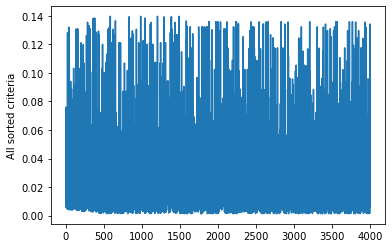

In [17]:
#The criterion shows convergence diuss_max
diuss.crit_behavior(all_crit = best_max[4])

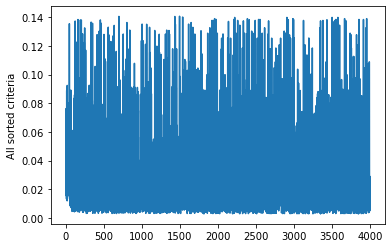

In [18]:
#The criterion shows convergence diuss_sum
diuss.crit_behavior(all_crit = best_sum[4])

In [19]:
print("KS: ",selected_sets["ks_sample"],"total_samples:",diuss.count_of_ones(array = selected_sets["ks_sample"]))
print("Duplex: ",selected_sets["duplex_sample"],"total_samples:",diuss.count_of_ones(array = selected_sets["duplex_sample"]))
print("puch_sample: ",selected_sets["puch_sample"],"total_samples:",diuss.count_of_ones(array = selected_sets["puch_sample"]))
print("clus_sample: ", selected_sets["clus_sample"],"total_samples:",diuss.count_of_ones(array = selected_sets["clus_sample"]))
print("diuss_max:",selected_sets["diuss_max"],"total_samples:",diuss.count_of_ones(array = selected_sets["diuss_max"]))
print("diuss_sum:",selected_sets["diuss_sum"],"total_samples:",diuss.count_of_ones(array = selected_sets["diuss_sum"]))
print("DOE:",selected_sets["DOE"],"total_samples:",diuss.count_of_ones(array = selected_sets["DOE"]))
print("all_samples:",selected_sets["all_samples"],"total_samples:",diuss.count_of_ones(array = selected_sets["all_samples"]))

KS:  [1 1 1 1 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 1 1 0 1 0 1 1 0 0 1 1 1 1 0 1 1
 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1] total_samples: 37
Duplex:  [0 0 0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 0 0 0
 1 1 0 1 1 0 1 1 1 1 1 1 0 1 0 0 1 0 1] total_samples: 37
puch_sample:  [1 1 1 1 1 0 1 1 1 0 1 0 1 0 0 1 1 0 1 0 1 1 1 1 1 0 1 1 0 0 1 0 1 1 0 1 1
 0 0 1 1 1 1 1 0 1 0 1 1 1 1 1 0 0 1 0] total_samples: 37
clus_sample:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0
 0 1 1 1 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0] total_samples: 37
diuss_max: [1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 0 0 1 1 0 0 0 1 1 0 0 1
 1 0 1 0 1 0 1 1 1 0 1 1 1 0 1 0 0 1 1] total_samples: 37
diuss_sum: [1 1 0 1 0 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1 1 1 1 0 0 0
 1 1 1 1 1 1 0 1 1 1 0 0 0 0 0 0 1 1 1] total_samples: 37
DOE: [1 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 0 0 0 1 0 0 1 0 1 1 1 1 1
 0 0 1 1 0 1 1 0 1 0 1 1 0 1 1 1 0 1 0] total_samples: 37


In [20]:
def sample_list(method_samples):
    l = len(method_samples)
    r=np.zeros((), dtype=int)

    for i in range(l):
        if method_samples[i] == 1:
            r=np.append(r,i)
    r=r[1:] # To eleiminate the first 0 from np.Zeros
    return(r)

In [21]:
Ks = sample_list(method_samples=selected_sets["ks_sample"])
dup = sample_list(method_samples=selected_sets["duplex_sample"])
puch = sample_list(method_samples=selected_sets["puch_sample"])
clus = sample_list(method_samples=selected_sets["clus_sample"])
d_max = sample_list(method_samples=selected_sets["diuss_max"])
d_sum = sample_list(method_samples=selected_sets["diuss_sum"])


In [43]:
print("ks")
print(Ks)
print("dup")
print(dup)
print("puch")
print(puch)
print("clus")
print(clus)
print("d_max")
print(d_max)
print("d_sum")
print(d_sum)
print("DOE")
print(DOE)

ks
[ 0  1  2  3  4  7  8 10 12 15 16 18 20 21 22 24 26 27 30 31 32 33 35 36
 39 40 41 42 43 44 45 47 48 49 50 51 55]
dup
[ 3  4  5  6  7  8  9 11 14 15 16 17 18 19 20 23 25 26 27 28 29 30 31 33
 37 38 40 41 43 44 45 46 47 48 50 53 55]
puch
[ 0  1  2  3  4  6  7  8 10 12 15 16 18 20 21 22 23 24 26 27 30 32 33 35
 36 39 40 41 42 43 45 47 48 49 50 51 54]
clus
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 20 22 23 24 25 26
 27 28 30 31 32 33 38 39 40 41 43 45 48]
d_max
[ 0  1  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 20 23 24 27 28 32 33
 36 37 39 41 43 44 45 47 48 49 51 54 55]
d_sum
[ 0  1  3  5  6  7  8 11 12 14 15 16 17 18 19 20 22 23 24 25 27 30 31 32
 33 37 38 39 40 41 42 44 45 46 53 54 55]
DOE
[ 0  1  2  3  4  6  7  9 10 12 13 15 16 17 18 20 21 22 23 27 30 32 33 34
 35 36 39 40 42 43 45 47 48 50 51 52 54]


In [28]:
# --- select one sample set for cal and eigenevaluation
svd_methods = {} # dictionary
# [] is a list

for method_name in selected_sets.keys():    

    selected_cal_set = selected_sets[method_name].copy()

    # --- evaluate selected cal set: S matrix eigen decomp

    x_selected = x_all[selected_cal_set==1,:]
    Xs_c = x_selected - x_selected.mean(axis=0)
    Xs_c_t = np.ascontiguousarray(Xs_c.transpose())
    cov_Xs = Xs_c_t.dot(Xs_c)/Xs_c.shape[0]
    svd_selected = np.linalg.svd(cov_Xs)
    
    svd_methods[method_name] = svd_selected
    
print("done")

done


determinant eigenvectors: 

ks_sample :  0.696
duplex_sample :  0.26
puch_sample :  0.69
clus_sample :  0.183
all_samples :  1.0
DOE :  0.811
diuss_max :  0.383
diuss_sum :  0.038


<ipython-input-29-695fb3db0d93>:36: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(xticks,eigen_vals_ratio, Linewidth = 2, label = method_name)
<ipython-input-29-695fb3db0d93>:36: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(xticks,eigen_vals_ratio, Linewidth = 2, label = method_name)
<ipython-input-29-695fb3db0d93>:36: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(xticks,eigen_vals_ratio, Linewidth = 2, label = method_name)
<ipython-input-29-695fb3db0d93>:36: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(xticks,eigen_vals_ratio, Linewidth = 2, label = method_name)
<ipython-input-29-695fb3db0d93>:34: 

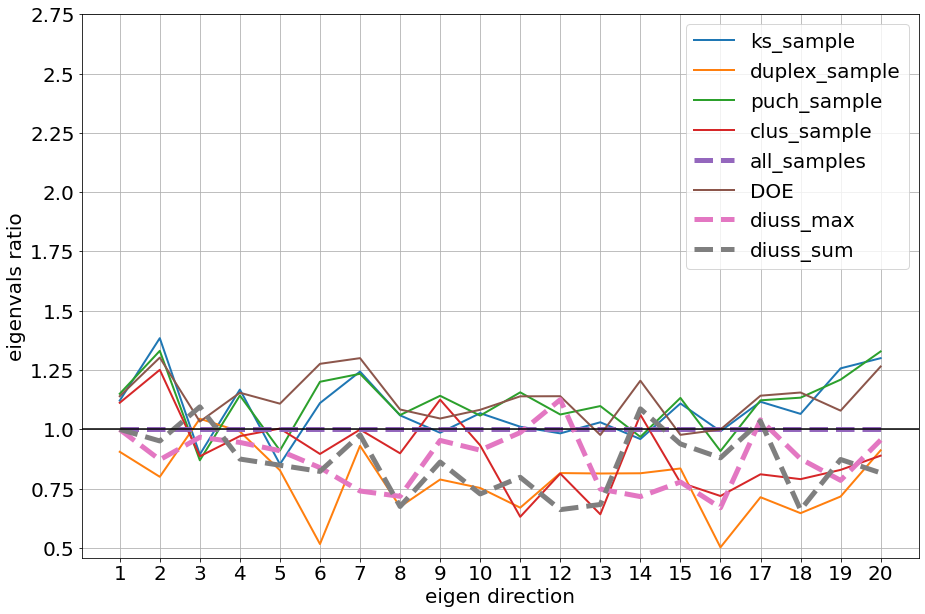

In [29]:
# --- visualize comparison svd
X_c = x_all - x_all.mean(axis=0)
X_c_t = np.ascontiguousarray(X_c.transpose())
cov_X = X_c_t.dot(X_c)/X_c.shape[0]
svd_cov_X = np.linalg.svd(cov_X)

# eigenvect comparison

print("determinant eigenvectors: \n")

for method_name in svd_methods.keys():
    
    svd_selected = svd_methods[method_name]
    eigen_vals_ratio = svd_selected[1][0:a]/svd_cov_X[1][0:a]
    eigen_vect_comparison = svd_selected[0][:,0:a].T.dot(svd_cov_X[0][:,0:a])
    eigen_vect_criterion = np.abs(np.linalg.det(eigen_vect_comparison))
    print(method_name,": ",np.round(eigen_vect_criterion,3))
    
    
# eigenval comparison

font_size = 20
yticks = np.arange(0.5,3, 0.25)
xticks = np.arange(1,a+1)


fig, ax = plt.subplots(figsize = (15,10))

for method_name in svd_methods.keys():
    
    svd_selected = svd_methods[method_name]
    eigen_vals_ratio = svd_selected[1][0:a]/svd_cov_X[1][0:a]
    if method_name =="diuss_max" or method_name =="diuss_sum" or method_name =="all_samples" :
        ax.plot(xticks,eigen_vals_ratio, Linewidth =5 , label = method_name, linestyle='dashed')
    else:
        ax.plot(xticks,eigen_vals_ratio, Linewidth = 2, label = method_name)

        
    
ax.grid()
ax.axhline(y=1, c = "black")
ax.set_xlabel("eigen direction", fontsize = font_size)
ax.set_xticks(xticks)
ax.set_xticklabels(labels = xticks, fontsize = font_size)
ax.set_ylabel("eigenvals ratio", fontsize = font_size)
ax.set_yticks(yticks)
ax.set_yticklabels(labels = yticks, fontsize = font_size)
ax.legend(fontsize = font_size)
plt.show()

## Cross validation PLSR model 

In [30]:
total_lv = 20
n_splits_cv = 10
n_shuffles = 1

## Moisture Cross Validation PLSR

In [1]:
model_evaluation = {}

for method_name in selected_sets.keys():
    
    selected_cal_set = selected_sets[method_name]
    xcal_pls = x_all[selected_cal_set==1,:]
    ycal_pls= Moisture_all[selected_cal_set==1,:]
    
    parameters = {'n_components': list(range(1,total_lv+1))}
    pls_scoring = {'r2': 'r2', 'rmse': 'neg_root_mean_squared_error'}
    
    for nn in range(n_shuffles):

        pls_cv = KFold(n_splits=n_splits_cv, shuffle=True)
        my_pls = PLSRegression(scale=False)
        my_pls_cv = GridSearchCV(my_pls, parameters, cv = pls_cv, scoring = pls_scoring, refit = False)
        my_pls_cv.fit( xcal_pls,  ycal_pls)
        
    model_evaluation[method_name] = {"rmsecv":-1*my_pls_cv.cv_results_["mean_test_rmse"],
                                    "r2cv":my_pls_cv.cv_results_["mean_test_r2"],
                                    }    
    # Note check this -1

NameError: name 'selected_sets' is not defined

<ipython-input-57-c12ee74a725e>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[0].plot(np.arange(1, total_lv+1),rmsecv, label = method_name, Linewidth =4,linestyle='dashed')
<ipython-input-57-c12ee74a725e>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[1].plot(np.arange(1, total_lv+1),r2cv, label = method_name, Linewidth =4,linestyle='dashed')
<ipython-input-57-c12ee74a725e>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[0].plot(np.arange(1, total_lv+1),rmsecv, label = method_name, Linewidth =4,linestyle='dashed')
<ipython-input-57-c12ee74a725e>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[1].plot(np.arange

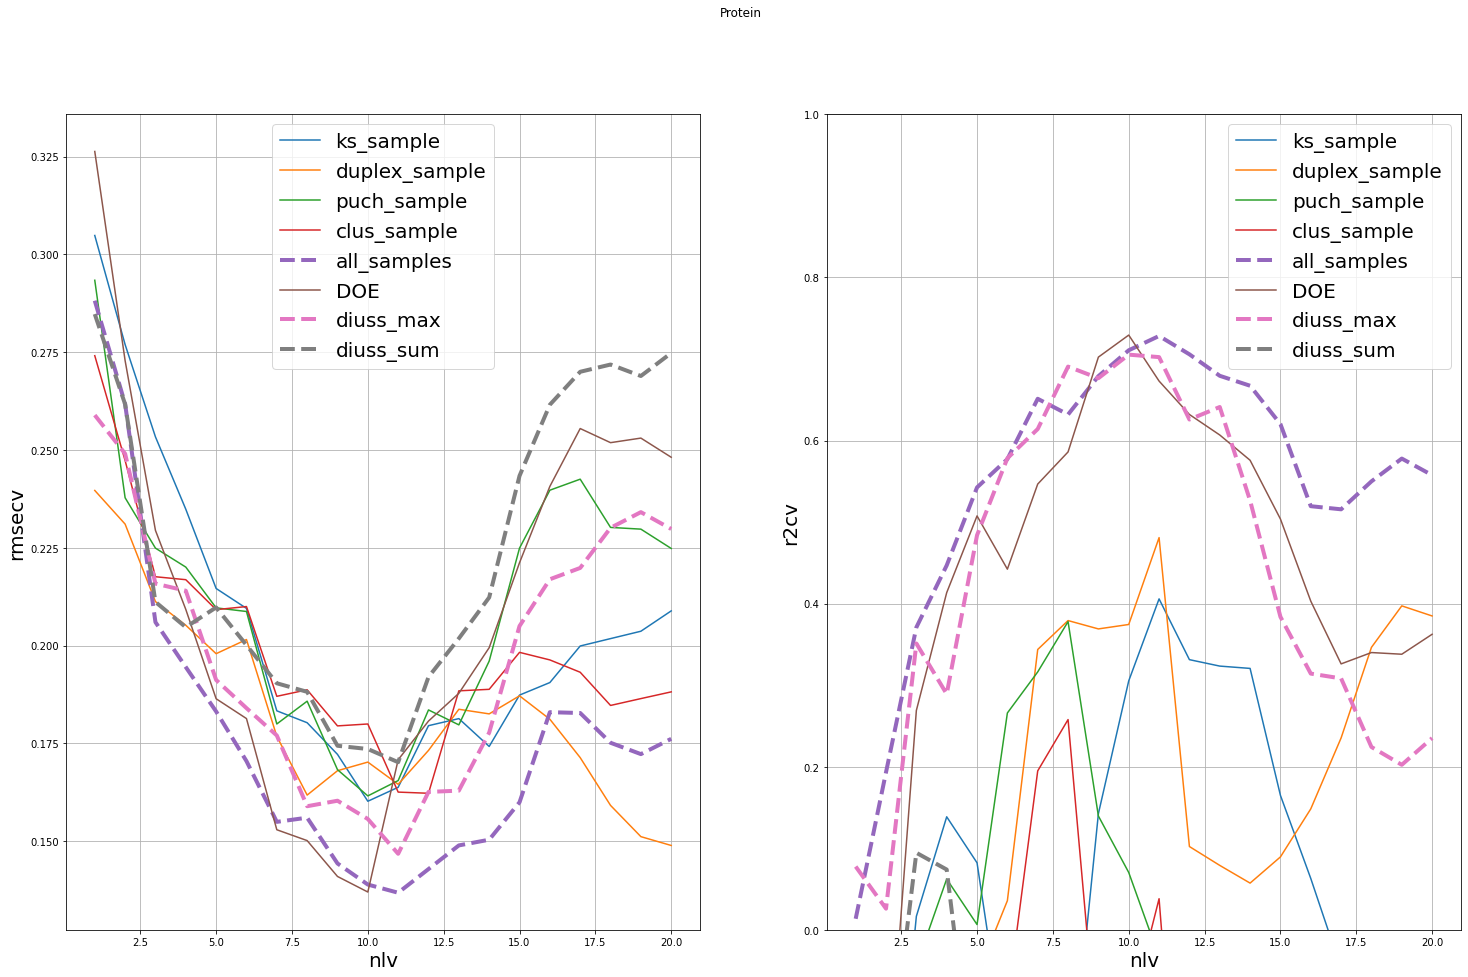

In [57]:
# Results Plots
fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (25,15))

for method_name in model_evaluation.keys():

    rmsecv = model_evaluation[method_name]["rmsecv"]
    r2cv = model_evaluation[method_name]["r2cv"]

    if method_name =='diuss_max' or method_name =='diuss_sum' or method_name =='all_samples'  :
        ax[0].plot(np.arange(1, total_lv+1),rmsecv, label = method_name, Linewidth =4,linestyle='dashed')
        ax[1].plot(np.arange(1, total_lv+1),r2cv, label = method_name, Linewidth =4,linestyle='dashed')        
    else:
        ax[0].plot(np.arange(1, total_lv+1),rmsecv, label = method_name)
        ax[1].plot(np.arange(1, total_lv+1),r2cv, label = method_name)

ax[0].set_xlabel("nlv", fontsize = font_size)
ax[1].set_xlabel("nlv", fontsize = font_size)

ax[0].set_ylabel("rmsecv", fontsize = font_size)
ax[1].set_ylabel("r2cv", fontsize = font_size)

ax[1].set_ylim([0,1])  

ax[0].grid()
ax[1].grid()

ax[0].legend(fontsize = font_size)
ax[1].legend(fontsize = font_size)

#y_name = "Moisture"
fig.suptitle(y_name)

plt.show()

## PLSR_Moisture

In [33]:
model_evaluation2 = {}

for method_name in selected_sets.keys():
    rmsep_all = np.zeros(total_lv)
    r2p_all = np.zeros(total_lv)
    
    selected_cal_set = selected_sets[method_name]
    xcal_pls = x_all[selected_cal_set==1,:]
    ycal_pls= Moisture_all[selected_cal_set==1,:]
    xtest_pls = x_test
    ytest_pls= Moisture_test
        
    for ii, chosen_lv in enumerate(range(1,total_lv+1)):
        
        my_pls = PLSRegression(n_components = chosen_lv,scale=False)
        my_pls.fit(xcal_pls, ycal_pls)
        x_mean = xcal_pls.mean(axis=0)
        y_mean = ycal_pls.mean(axis=0)
        
        # deliver model
        B = my_pls.coef_
        beta = y_mean - (x_mean.dot(B))

        ytest_pls_pred = xtest_pls.dot(B) + beta
        rmsep_all[ii] = np.sqrt(mean_squared_error(ytest_pls, ytest_pls_pred))
        r2p_all[ii] = r2_score(ytest_pls, ytest_pls_pred)
        
    model_evaluation2[method_name] = {"rmsep":rmsep_all,
                                    "r2p":r2p_all,
                                    }    

<ipython-input-65-e7367f0fd4cf>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[0].plot(np.arange(1, total_lv+1),rmsep, label = method_name, Linewidth =3,linestyle='dashed')
<ipython-input-65-e7367f0fd4cf>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[1].plot(np.arange(1, total_lv+1),r2p, label = method_name, Linewidth =3,linestyle='dashed')
<ipython-input-65-e7367f0fd4cf>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[0].plot(np.arange(1, total_lv+1),rmsep, label = method_name, Linewidth =3,linestyle='dashed')
<ipython-input-65-e7367f0fd4cf>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[1].plot(np.arange(1,

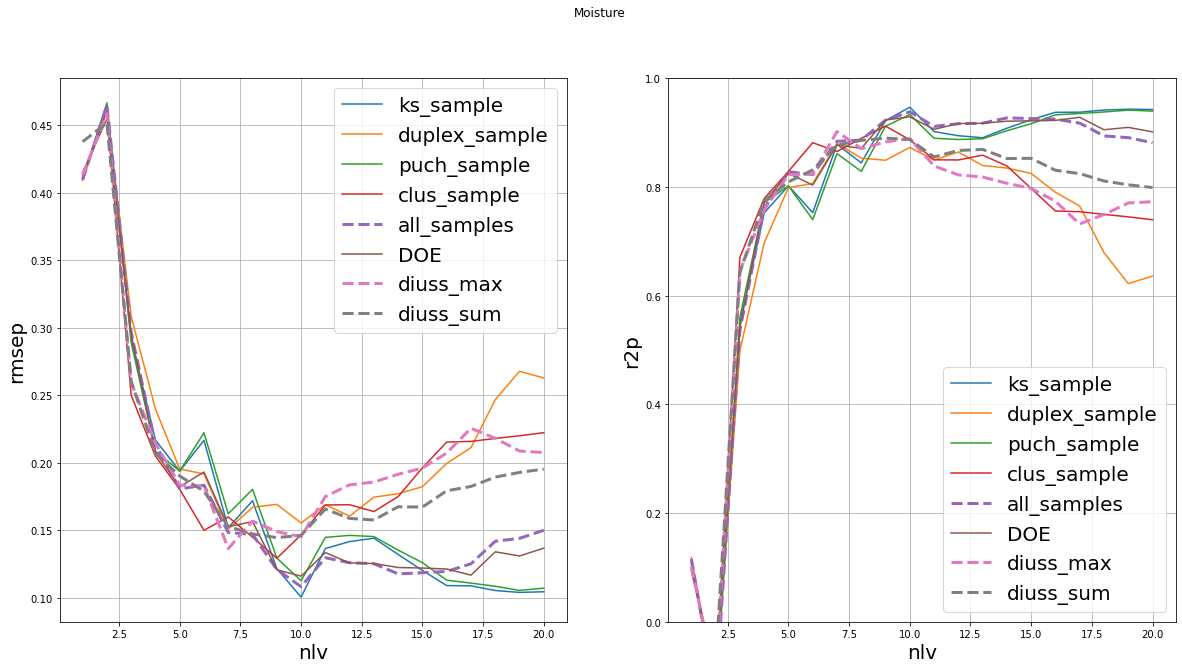

In [65]:
# Results Plots
fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,10))

for method_name in model_evaluation2.keys():

    rmsep = model_evaluation2[method_name]["rmsep"]
    r2p = model_evaluation2[method_name]["r2p"]

    if method_name =='diuss_max' or method_name =='diuss_sum' or method_name =='all_samples'  :
        ax[0].plot(np.arange(1, total_lv+1),rmsep, label = method_name, Linewidth =3,linestyle='dashed')
        ax[1].plot(np.arange(1, total_lv+1),r2p, label = method_name, Linewidth =3,linestyle='dashed')        
    else:
        ax[0].plot(np.arange(1, total_lv+1),rmsep, label = method_name)
        ax[1].plot(np.arange(1, total_lv+1),r2p, label = method_name)

ax[0].set_xlabel("nlv", fontsize = font_size)
ax[1].set_xlabel("nlv", fontsize = font_size)

ax[0].set_ylabel("rmsep", fontsize = font_size)
ax[1].set_ylabel("r2p", fontsize = font_size)
     
ax[1].set_ylim([0,1])    

ax[0].grid()
ax[1].grid()

ax[0].legend(fontsize = font_size)
ax[1].legend(fontsize = font_size)

y_name = "Moisture"
fig.suptitle(y_name)

plt.show()



## Oil_Cross Validation PLSR

In [35]:
model_evaluation = {}

for method_name in selected_sets.keys():
    
    selected_cal_set = selected_sets[method_name]
    xcal_pls = x_all[selected_cal_set==1,:]
    ycal_pls= Oil_all[selected_cal_set==1,:]
    
    parameters = {'n_components': list(range(1,total_lv+1))}
    pls_scoring = {'r2': 'r2', 'rmse': 'neg_root_mean_squared_error'}
    
    for nn in range(n_shuffles):

        pls_cv = KFold(n_splits=n_splits_cv, shuffle=True)
        my_pls = PLSRegression(scale=False)
        my_pls_cv = GridSearchCV(my_pls, parameters, cv = pls_cv, scoring = pls_scoring, refit = False)
        my_pls_cv.fit( xcal_pls,  ycal_pls)
        
    model_evaluation[method_name] = {"rmsecv":-1*my_pls_cv.cv_results_["mean_test_rmse"],
                                    "r2cv":my_pls_cv.cv_results_["mean_test_r2"],
                                    }    
  

<ipython-input-36-873263b4dea0>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[0].plot(np.arange(1, total_lv+1),rmsecv, label = method_name, Linewidth =4,linestyle='dashed')
<ipython-input-36-873263b4dea0>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[1].plot(np.arange(1, total_lv+1),r2cv, label = method_name, Linewidth =4,linestyle='dashed')
<ipython-input-36-873263b4dea0>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[0].plot(np.arange(1, total_lv+1),rmsecv, label = method_name, Linewidth =4,linestyle='dashed')
<ipython-input-36-873263b4dea0>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[1].plot(np.arange

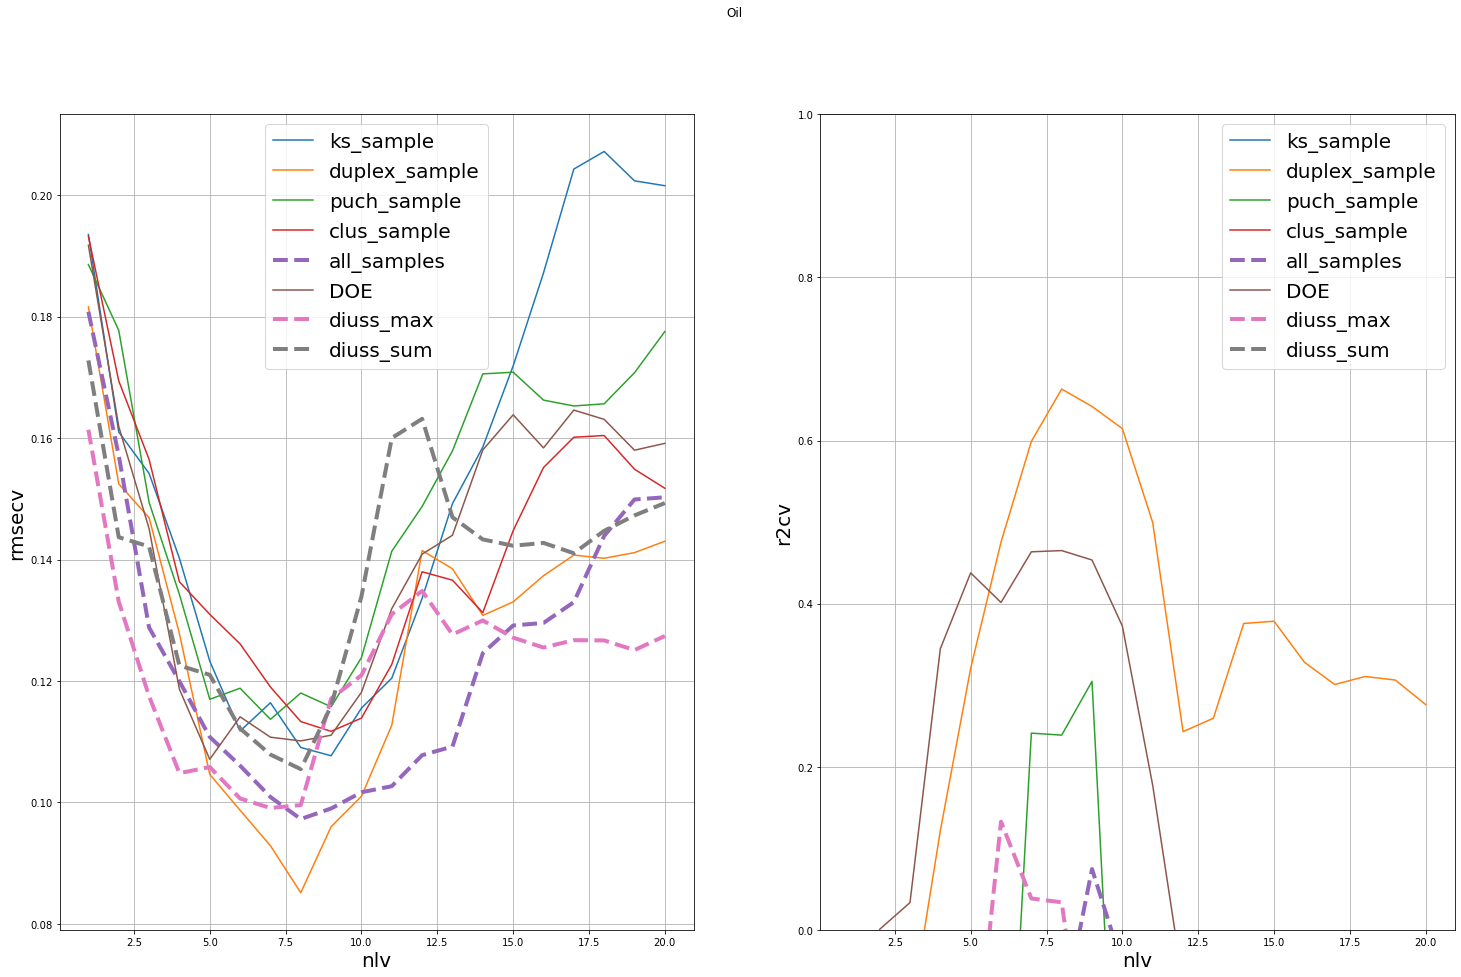

In [36]:
# Results Plots
fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (25,15))

for method_name in model_evaluation.keys():

    rmsecv = model_evaluation[method_name]["rmsecv"]
    r2cv = model_evaluation[method_name]["r2cv"]

    if method_name =='diuss_max' or method_name =='diuss_sum' or method_name =='all_samples'  :
        ax[0].plot(np.arange(1, total_lv+1),rmsecv, label = method_name, Linewidth =4,linestyle='dashed')
        ax[1].plot(np.arange(1, total_lv+1),r2cv, label = method_name, Linewidth =4,linestyle='dashed')        
    else:
        ax[0].plot(np.arange(1, total_lv+1),rmsecv, label = method_name)
        ax[1].plot(np.arange(1, total_lv+1),r2cv, label = method_name)

ax[0].set_xlabel("nlv", fontsize = font_size)
ax[1].set_xlabel("nlv", fontsize = font_size)

ax[0].set_ylabel("rmsecv", fontsize = font_size)
ax[1].set_ylabel("r2cv", fontsize = font_size)

ax[1].set_ylim([0,1])  

ax[0].grid()
ax[1].grid()

ax[0].legend(fontsize = font_size)
ax[1].legend(fontsize = font_size)

y_name = "Oil"
fig.suptitle(y_name)

plt.show()

## PLSR_Oil

In [37]:
model_evaluation2 = {}

for method_name in selected_sets.keys():
    rmsep_all = np.zeros(total_lv)
    r2p_all = np.zeros(total_lv)
    
    selected_cal_set = selected_sets[method_name]
    xcal_pls = x_all[selected_cal_set==1,:]
    ycal_pls= Oil_all[selected_cal_set==1,:]
    xtest_pls = x_test
    ytest_pls= Oil_test
        
    for ii, chosen_lv in enumerate(range(1,total_lv+1)):
        
        my_pls = PLSRegression(n_components = chosen_lv,scale=False)
        my_pls.fit(xcal_pls, ycal_pls)
        x_mean = xcal_pls.mean(axis=0)
        y_mean = ycal_pls.mean(axis=0)
        
        # deliver model
        B = my_pls.coef_
        beta = y_mean - (x_mean.dot(B))

        ytest_pls_pred = xtest_pls.dot(B) + beta
        rmsep_all[ii] = np.sqrt(mean_squared_error(ytest_pls, ytest_pls_pred))
        r2p_all[ii] = r2_score(ytest_pls, ytest_pls_pred)
        
    model_evaluation2[method_name] = {"rmsep":rmsep_all,
                                    "r2p":r2p_all,
                                    }    

<ipython-input-38-74edd96bd185>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[0].plot(np.arange(1, total_lv+1),rmsep, label = method_name, Linewidth =3,linestyle='dashed')
<ipython-input-38-74edd96bd185>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[1].plot(np.arange(1, total_lv+1),r2p, label = method_name, Linewidth =3,linestyle='dashed')
<ipython-input-38-74edd96bd185>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[0].plot(np.arange(1, total_lv+1),rmsep, label = method_name, Linewidth =3,linestyle='dashed')
<ipython-input-38-74edd96bd185>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[1].plot(np.arange(1,

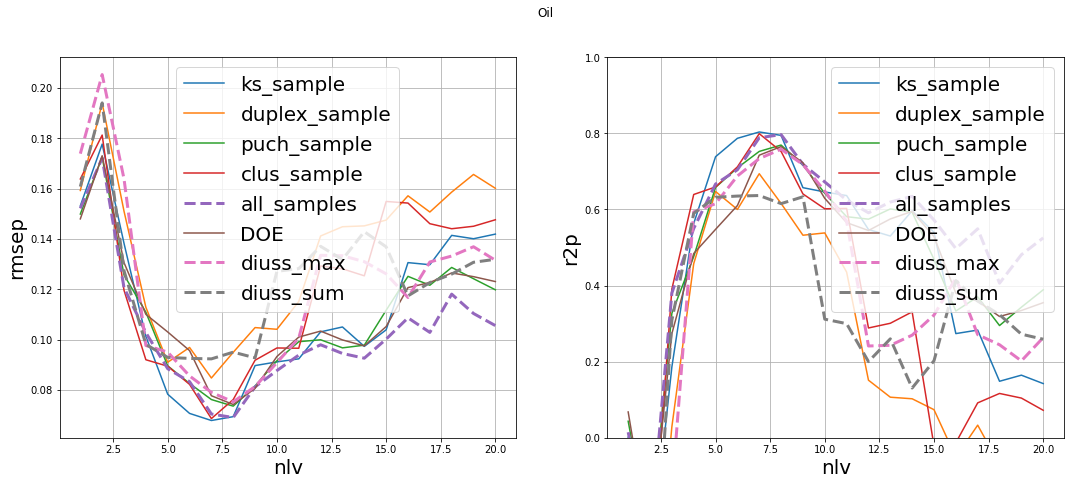

In [38]:
# Results Plots
fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,7))

for method_name in model_evaluation2.keys():

    rmsep = model_evaluation2[method_name]["rmsep"]
    r2p = model_evaluation2[method_name]["r2p"]

    if method_name =='diuss_max' or method_name =='diuss_sum' or method_name =='all_samples'  :
        ax[0].plot(np.arange(1, total_lv+1),rmsep, label = method_name, Linewidth =3,linestyle='dashed')
        ax[1].plot(np.arange(1, total_lv+1),r2p, label = method_name, Linewidth =3,linestyle='dashed')        
    else:
        ax[0].plot(np.arange(1, total_lv+1),rmsep, label = method_name)
        ax[1].plot(np.arange(1, total_lv+1),r2p, label = method_name)

ax[0].set_xlabel("nlv", fontsize = font_size)
ax[1].set_xlabel("nlv", fontsize = font_size)

ax[0].set_ylabel("rmsep", fontsize = font_size)
ax[1].set_ylabel("r2p", fontsize = font_size)

    
ax[1].set_ylim([0,1])    

ax[0].grid()
ax[1].grid()

ax[0].legend(fontsize = font_size)
ax[1].legend(fontsize = font_size)

y_name = "Oil"
fig.suptitle(y_name)

plt.show()



## Protein Cross Validation PLSR

In [39]:
model_evaluation = {}

for method_name in selected_sets.keys():
    
    selected_cal_set = selected_sets[method_name]
    xcal_pls = x_all[selected_cal_set==1,:]
    ycal_pls= Protein_all[selected_cal_set==1,:]
    
    parameters = {'n_components': list(range(1,total_lv+1))}
    pls_scoring = {'r2': 'r2', 'rmse': 'neg_root_mean_squared_error'}
    
    for nn in range(n_shuffles):

        pls_cv = KFold(n_splits=n_splits_cv, shuffle=True)
        my_pls = PLSRegression(scale=False)
        my_pls_cv = GridSearchCV(my_pls, parameters, cv = pls_cv, scoring = pls_scoring, refit = False)
        my_pls_cv.fit( xcal_pls,  ycal_pls)
        
    model_evaluation[method_name] = {"rmsecv":-1*my_pls_cv.cv_results_["mean_test_rmse"],
                                    "r2cv":my_pls_cv.cv_results_["mean_test_r2"],
                                    }    
    # Note check this -1

<ipython-input-40-8541341a7dbd>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[0].plot(np.arange(1, total_lv+1),rmsecv, label = method_name, Linewidth =4,linestyle='dashed')
<ipython-input-40-8541341a7dbd>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[1].plot(np.arange(1, total_lv+1),r2cv, label = method_name, Linewidth =4,linestyle='dashed')
<ipython-input-40-8541341a7dbd>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[0].plot(np.arange(1, total_lv+1),rmsecv, label = method_name, Linewidth =4,linestyle='dashed')
<ipython-input-40-8541341a7dbd>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[1].plot(np.arange

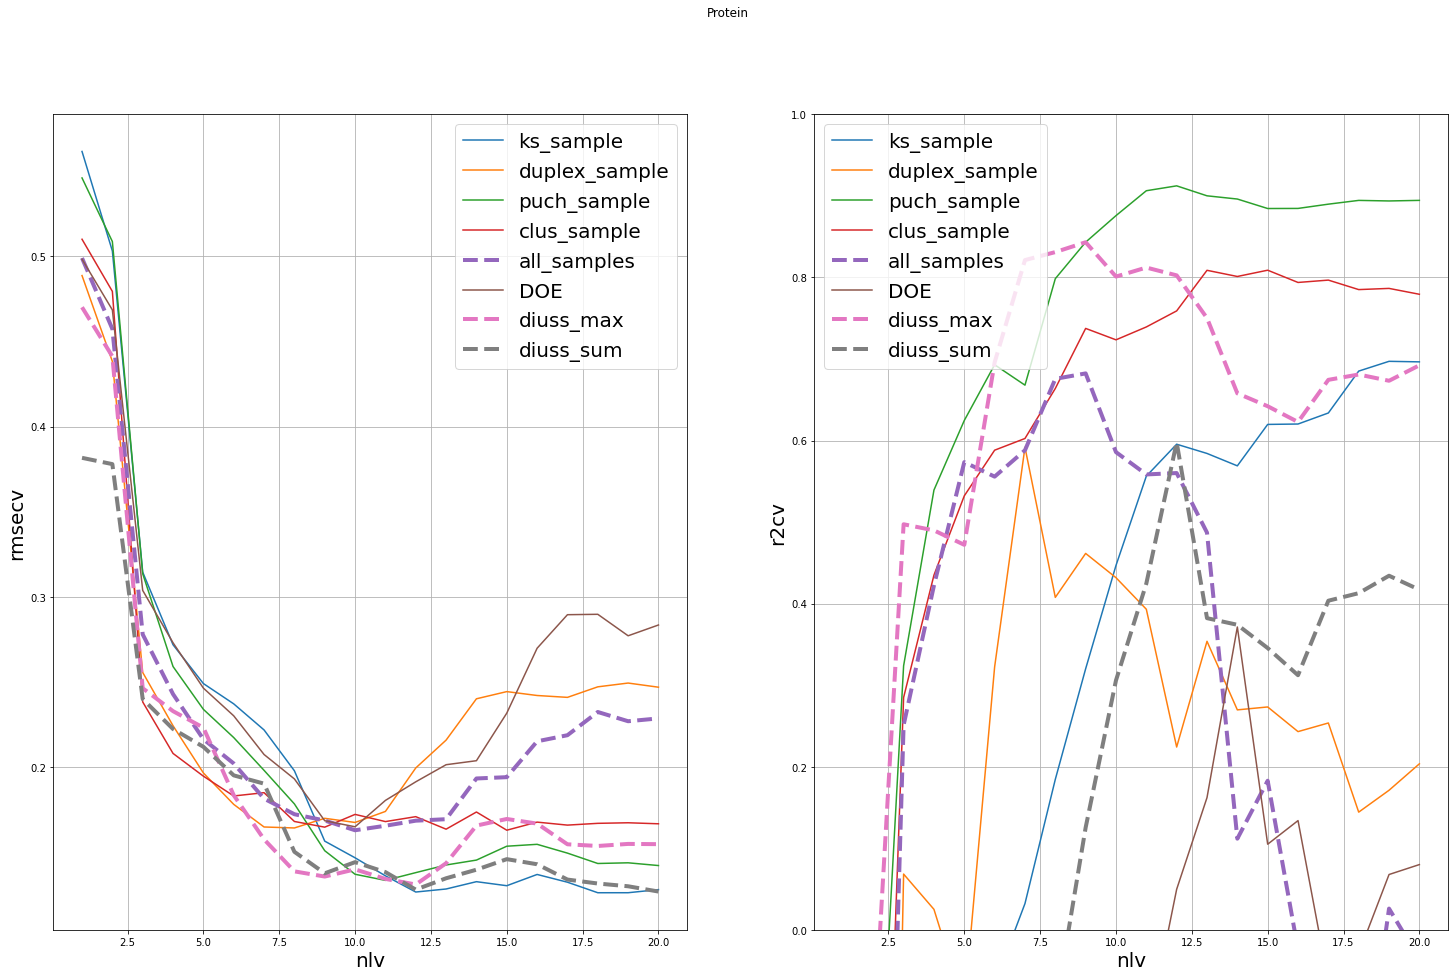

In [40]:
# Results Plots
fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (25,15))

for method_name in model_evaluation.keys():

    rmsecv = model_evaluation[method_name]["rmsecv"]
    r2cv = model_evaluation[method_name]["r2cv"]

    if method_name =='diuss_max' or method_name =='diuss_sum' or method_name =='all_samples'  :
        ax[0].plot(np.arange(1, total_lv+1),rmsecv, label = method_name, Linewidth =4,linestyle='dashed')
        ax[1].plot(np.arange(1, total_lv+1),r2cv, label = method_name, Linewidth =4,linestyle='dashed')        
    else:
        ax[0].plot(np.arange(1, total_lv+1),rmsecv, label = method_name)
        ax[1].plot(np.arange(1, total_lv+1),r2cv, label = method_name)

ax[0].set_xlabel("nlv", fontsize = font_size)
ax[1].set_xlabel("nlv", fontsize = font_size)

ax[0].set_ylabel("rmsecv", fontsize = font_size)
ax[1].set_ylabel("r2cv", fontsize = font_size)

ax[1].set_ylim([0,1])  

ax[0].grid()
ax[1].grid()

ax[0].legend(fontsize = font_size)
ax[1].legend(fontsize = font_size)

y_name = "Protein"
fig.suptitle(y_name)

plt.show()

## Protein PLSR

In [41]:
model_evaluation2 = {}

for method_name in selected_sets.keys():
    rmsep_all = np.zeros(total_lv)
    r2p_all = np.zeros(total_lv)
    
    selected_cal_set = selected_sets[method_name]
    xcal_pls = x_all[selected_cal_set==1,:]
    ycal_pls= Protein_all[selected_cal_set==1,:]
    xtest_pls = x_test
    ytest_pls= Protein_test
        
    for ii, chosen_lv in enumerate(range(1,total_lv+1)):
        
        my_pls = PLSRegression(n_components = chosen_lv,scale=False)
        my_pls.fit(xcal_pls, ycal_pls)
        x_mean = xcal_pls.mean(axis=0)
        y_mean = ycal_pls.mean(axis=0)
        
        # deliver model
        B = my_pls.coef_
        beta = y_mean - (x_mean.dot(B))

        ytest_pls_pred = xtest_pls.dot(B) + beta
        rmsep_all[ii] = np.sqrt(mean_squared_error(ytest_pls, ytest_pls_pred))
        r2p_all[ii] = r2_score(ytest_pls, ytest_pls_pred)
        
    model_evaluation2[method_name] = {"rmsep":rmsep_all,
                                    "r2p":r2p_all,
                                    }    

<ipython-input-42-de6569857bf4>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[0].plot(np.arange(1, total_lv+1),rmsep, label = method_name, Linewidth =3,linestyle='dashed')
<ipython-input-42-de6569857bf4>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[1].plot(np.arange(1, total_lv+1),r2p, label = method_name, Linewidth =3,linestyle='dashed')
<ipython-input-42-de6569857bf4>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[0].plot(np.arange(1, total_lv+1),rmsep, label = method_name, Linewidth =3,linestyle='dashed')
<ipython-input-42-de6569857bf4>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[1].plot(np.arange(1,

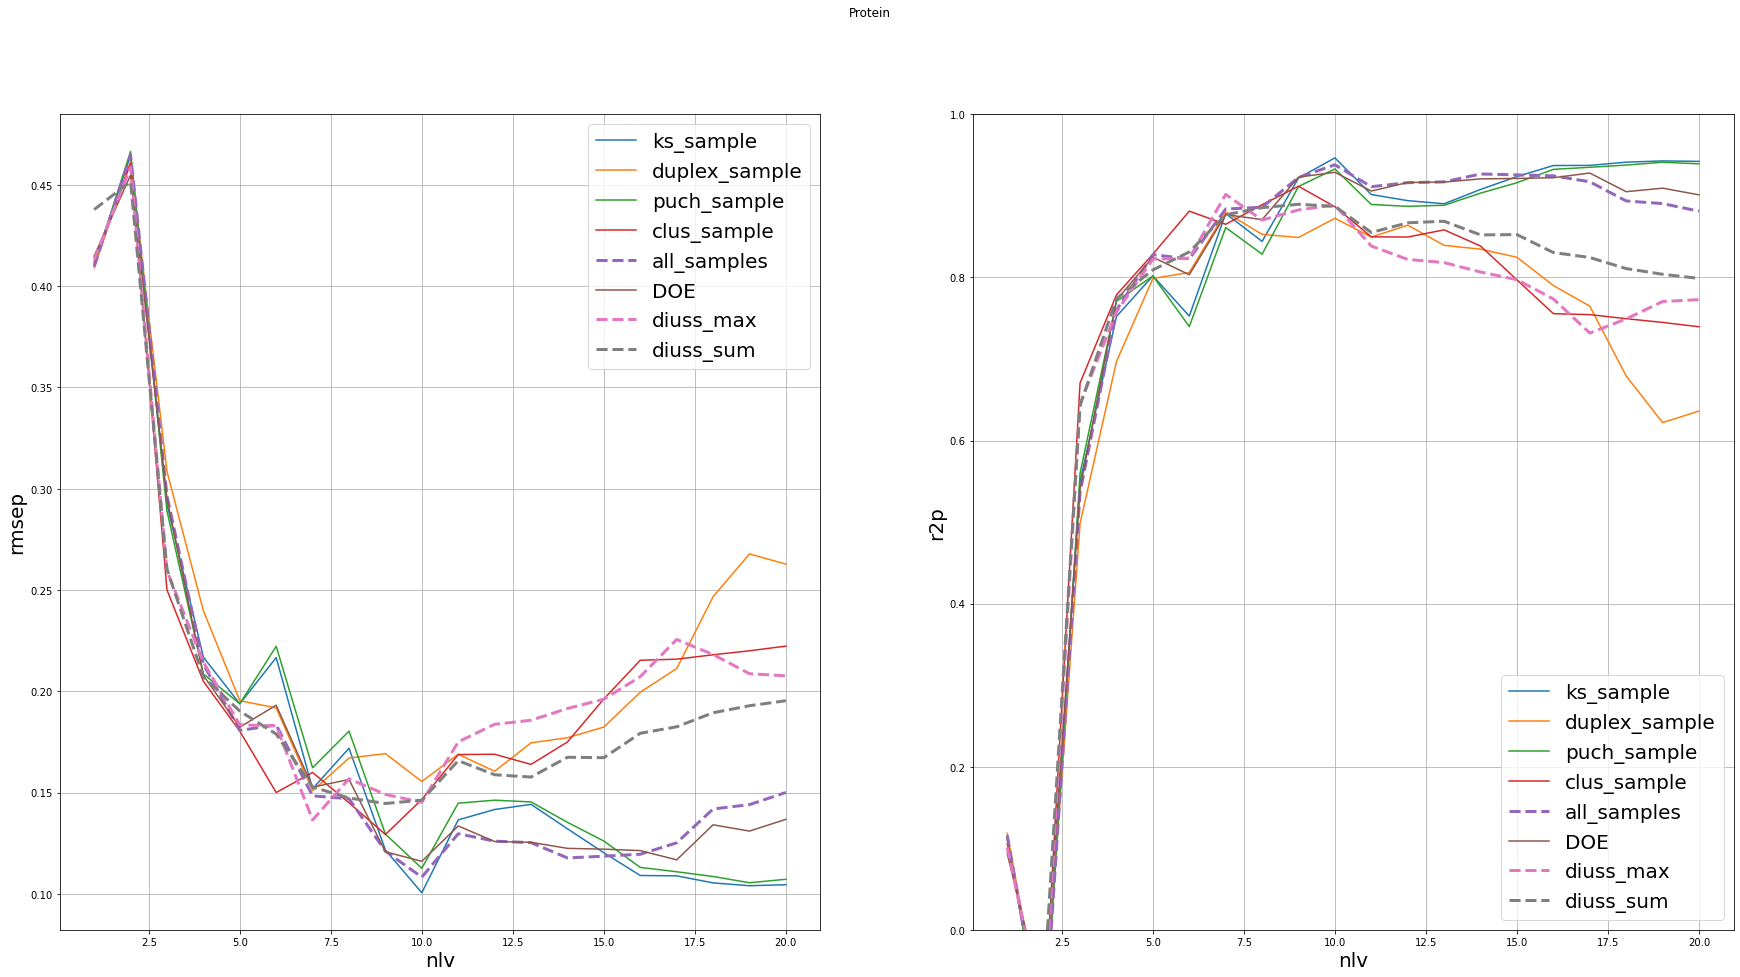

In [42]:
# Results Plots
fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (30,15))

for method_name in model_evaluation2.keys():

    rmsep = model_evaluation2[method_name]["rmsep"]
    r2p = model_evaluation2[method_name]["r2p"]

    if method_name =='diuss_max' or method_name =='diuss_sum' or method_name =='all_samples'  :
        ax[0].plot(np.arange(1, total_lv+1),rmsep, label = method_name, Linewidth =3,linestyle='dashed')
        ax[1].plot(np.arange(1, total_lv+1),r2p, label = method_name, Linewidth =3,linestyle='dashed')        
    else:
        ax[0].plot(np.arange(1, total_lv+1),rmsep, label = method_name)
        ax[1].plot(np.arange(1, total_lv+1),r2p, label = method_name)

ax[0].set_xlabel("nlv", fontsize = font_size)
ax[1].set_xlabel("nlv", fontsize = font_size)

ax[0].set_ylabel("rmsep", fontsize = font_size)
ax[1].set_ylabel("r2p", fontsize = font_size)

ax[0].grid()
ax[1].grid()

  
ax[1].set_ylim([0,1])    

ax[0].legend(fontsize = font_size)
ax[1].legend(fontsize = font_size)

y_name = "Protein"
fig.suptitle(y_name)

plt.show()



## Starch Cross Validation PLSR

In [ ]:
model_evaluation = {}

for method_name in selected_sets.keys():
    
    selected_cal_set = selected_sets[method_name]
    xcal_pls = x_all[selected_cal_set==1,:]
    ycal_pls= Starch_all[selected_cal_set==1,:]
    
    parameters = {'n_components': list(range(1,total_lv+1))}
    pls_scoring = {'r2': 'r2', 'rmse': 'neg_root_mean_squared_error'}
    
    for nn in range(n_shuffles):

        pls_cv = KFold(n_splits=n_splits_cv, shuffle=True)
        my_pls = PLSRegression(scale=False)
        my_pls_cv = GridSearchCV(my_pls, parameters, cv = pls_cv, scoring = pls_scoring, refit = False)
        my_pls_cv.fit( xcal_pls,  ycal_pls)
        
    model_evaluation[method_name] = {"rmsecv":-1*my_pls_cv.cv_results_["mean_test_rmse"],
                                    "r2cv":my_pls_cv.cv_results_["mean_test_r2"],
                                    }    
    # Note check this -1

In [ ]:
# Results Plots
fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (25,15))

for method_name in model_evaluation.keys():

    rmsecv = model_evaluation[method_name]["rmsecv"]
    r2cv = model_evaluation[method_name]["r2cv"]

    if method_name =='diuss_max' or method_name =='diuss_sum' or method_name =='all_samples'  :
        ax[0].plot(np.arange(1, total_lv+1),rmsecv, label = method_name, Linewidth =4,linestyle='dashed')
        ax[1].plot(np.arange(1, total_lv+1),r2cv, label = method_name, Linewidth =4,linestyle='dashed')        
    else:
        ax[0].plot(np.arange(1, total_lv+1),rmsecv, label = method_name)
        ax[1].plot(np.arange(1, total_lv+1),r2cv, label = method_name)

ax[0].set_xlabel("nlv", fontsize = font_size)
ax[1].set_xlabel("nlv", fontsize = font_size)

ax[0].set_ylabel("rmsecv", fontsize = font_size)
ax[1].set_ylabel("r2cv", fontsize = font_size)

ax[1].set_ylim([0,1])  

ax[0].grid()
ax[1].grid()

ax[0].legend(fontsize = font_size)
ax[1].legend(fontsize = font_size)

y_name = "Starch"
fig.suptitle(y_name)

plt.show()

## Starch PLSR

In [ ]:
model_evaluation2 = {}

for method_name in selected_sets.keys():
    rmsep_all = np.zeros(total_lv)
    r2p_all = np.zeros(total_lv)
    
    selected_cal_set = selected_sets[method_name]
    xcal_pls = x_all[selected_cal_set==1,:]
    ycal_pls= Starch_all[selected_cal_set==1,:]
    xtest_pls = x_test
    ytest_pls= Starch_test
        
    for ii, chosen_lv in enumerate(range(1,total_lv+1)):
        
        my_pls = PLSRegression(n_components = chosen_lv,scale=False)
        my_pls.fit(xcal_pls, ycal_pls)
        x_mean = xcal_pls.mean(axis=0)
        y_mean = ycal_pls.mean(axis=0)
        
        # deliver model
        B = my_pls.coef_
        beta = y_mean - (x_mean.dot(B))

        ytest_pls_pred = xtest_pls.dot(B) + beta
        rmsep_all[ii] = np.sqrt(mean_squared_error(ytest_pls, ytest_pls_pred))
        r2p_all[ii] = r2_score(ytest_pls, ytest_pls_pred)
        
    model_evaluation2[method_name] = {"rmsep":rmsep_all,
                                    "r2p":r2p_all,
                                    }    

In [ ]:
# Results Plots
fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (30,15))

for method_name in model_evaluation2.keys():

    rmsep = model_evaluation2[method_name]["rmsep"]
    r2p = model_evaluation2[method_name]["r2p"]

    if method_name =='diuss_max' or method_name =='diuss_sum' or method_name =='all_samples'  :
        ax[0].plot(np.arange(1, total_lv+1),rmsep, label = method_name, Linewidth =3,linestyle='dashed')
        ax[1].plot(np.arange(1, total_lv+1),r2p, label = method_name, Linewidth =3,linestyle='dashed')        
    else:
        ax[0].plot(np.arange(1, total_lv+1),rmsep, label = method_name)
        ax[1].plot(np.arange(1, total_lv+1),r2p, label = method_name)

ax[0].set_xlabel("nlv", fontsize = font_size)
ax[1].set_xlabel("nlv", fontsize = font_size)

ax[0].set_ylabel("rmsep", fontsize = font_size)
ax[1].set_ylabel("r2p", fontsize = font_size)

ax[0].grid()
ax[1].grid()

ax[1].set_ylim([0,1])   

ax[0].legend(fontsize = font_size)
ax[1].legend(fontsize = font_size)

y_name = "Starch"
fig.suptitle(y_name)

plt.show()

